# Cyberbullying Detection in Social Media

**Niv Shani (ID. 311361661)**

Submitted as final project for the NLP course, Reichman University, 2023

The general idea of this project is to train an offensive tweets classification, for the purpose of identifying trending targets that are potentially bullied in social media.

Given a dataset of tweets, we can classify them and extract the _targeted_ offensive tweets, then analyze the frequent subjects. This will highlight the trending subjects of cyberbullying for that given dataset.

### References

**All links are also available in the submitted report PDF.**  
**Dataset and .csv files references in cells below are attached in the notebook folder.**

* [Offensive Language Identification Dataset (OLID)](https://sites.google.com/site/offensevalsharedtask/olid?authuser=0)
* [Complete Trump Tweets](https://www.kaggle.com/datasets/markhhuang/complete-trump-tweets)
* [sklearn.linear\_model.LogisticRegressionCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html)
* [finiteautomata/bertweet-base-sentiment-analysis](https://www.huggingface.co/finiteautomata/bertweet-base-sentiment-analysis)
* [sklearn.feature_extraction.text.TfidfTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)
* [nltk.corpus.stop_words](https://www.nltk.org/search.html?q=stopwords)

In [579]:
# Requirements

!pip install pydantic
!pip install emoji
!pip install wordcloud
!pip install spacy
!python -m spacy download en_core_web_sm


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 962.5 kB/s eta 0:00:00m eta 0:00:010:01:01



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [786]:
# Imports

from typing import Tuple, List, Dict, Optional, Literal
from pydantic import BaseModel

import warnings
import csv
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
import emoji
import spacy

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from nltk.tokenize import TweetTokenizer
from nltk import bigrams
from nltk.probability import FreqDist
from nltk.corpus import stopwords

from wordcloud import WordCloud
from transformers import pipeline

In [680]:
# Globals

TRAIN_DS = './olid_dataset/olid-training-v1.0.tsv'

TEST_DS_LVL_A = './olid_dataset/testset-levela.tsv'
TEST_DS_LVL_B = './olid_dataset/testset-levelb.tsv'
TEST_DS_LVL_C = './olid_dataset/testset-levelc.tsv'
TEST_LABELS_LVL_A = './olid_dataset/labels-levela.csv'
TEST_LABELS_LVL_B = './olid_dataset/labels-levelb.csv'
TEST_LABELS_LVL_C = './olid_dataset/labels-levelc.csv'

TRUMP_TWEETS_BEFORE_OFFICE = './trump_before_office.csv'
TRUMP_TWEETS_IN_OFFICE = './trump_in_office.csv'
TRUMP_TWEETS_SAMPLE_SIZE = 5000

CLASS_TO_LABEL = {'NOT': 1, 'OFF': 2, 'IND': 3, 'GRP': 4, 'OTH': 5}
LABEL_TO_CLASS = {1: 'NOT', 2: 'OFF', 3: 'IND', 4: 'GRP', 5: 'OTH'}

nltk.download('stopwords') 
nltk.download('punkt') 
spacy_nlp = spacy.load("en_core_web_sm")

warnings.filterwarnings('ignore')

[nltk_data] Error loading stopwords: <urlopen error [Errno 65] No
[nltk_data]     route to host>
[nltk_data] Error loading punkt: <urlopen error [Errno 8] nodename nor
[nltk_data]     servname provided, or not known>


In [674]:
# Utilities
    
class Utilities:
    def extract_hashtags(self, tweet: str) -> List[str]:
        hashtags = [word.lower().split('#')[1:] for word in tweet.split() if word.startswith('#')]
        return list(np.concatenate(hashtags) if hashtags else [])

    def extract_emojis(self, tweet: str) -> List[str]:
        tweet_emojis = emoji.analyze(tweet, join_emoji=True)
        emoji_list = [t.chars for t in list(tweet_emojis)]
        return emoji_list

    def strip_emojis(self, tweet: str) -> str:
        tweet_wo_emojis = emoji.replace_emoji(tweet, replace="")
        return re.sub('\s+', ' ', tweet_wo_emojis)

    def sanitize_tweet(self, tweet: str) -> Tuple[str, List[str], List[str]]:
        hashtags = self.extract_hashtags(tweet)
        emojis = self.extract_emojis(tweet)
        cleaned_text = self.strip_emojis(tweet)

        return cleaned_text, hashtags, emojis
    
    def tokenize_tweet(self, tweet: str, 
                       target_pos: Optional[List[str]] = None, 
                       skip_tokens: Optional[List[str]] = []) -> List[str]:
        stop_words = set(stopwords.words('english') + ['user', 'url'] + skip_tokens)
        word_tokens = [word.lower() for word in nltk.word_tokenize(tweet)
                       if word.isalnum() and word.lower() not in stop_words]
        
        if target_pos:
            pos_tagged_tokens = spacy_nlp(" ".join(word_tokens))
            return [t.lemma_ for t in pos_tagged_tokens if t.pos_ in target_pos]
        else:
            return word_tokens


TweetUtils = Utilities()

---

### Data pre-processing

In [681]:
train_ds = pd.read_csv(TRAIN_DS, sep='\t', header=0, 
                       names=['uid', 'text', 'offensive', 'targeted', 'target_type'])

test_lvl_a = pd.read_csv(TEST_DS_LVL_A, sep='\t', header=0, names=['uid', 'text'])
test_lvl_a_labels = pd.read_csv(TEST_LABELS_LVL_A, header=0, names=['uid', 'offensive'])
test_lvl_b_labels = pd.read_csv(TEST_LABELS_LVL_B, header=0, names=['uid', 'targeted'])
test_lvl_c_labels = pd.read_csv(TEST_LABELS_LVL_C, header=0, names=['uid', 'target_type'])

trump_tweets_in_office_ds = pd.read_csv(TRUMP_TWEETS_IN_OFFICE, 
                                        header=0, 
                                        usecols=["Tweet URL", "Tweet Text"], 
                                        on_bad_lines='skip',
                                        converters={"Tweet URL": lambda url:url.split('/')[-1]},
                                        names=['ID', 'Time', 'Tweet URL', 'Tweet Text'])

trump_tweets_before_office_ds = pd.read_csv(TRUMP_TWEETS_BEFORE_OFFICE, 
                                            header=0, 
                                            usecols=["Tweet URL", "Tweet Text"], 
                                            on_bad_lines='skip',
                                            converters={"Tweet URL": lambda url: url.split('/')[-1]},
                                            names=['ID', 'Time', 'Tweet URL', 'Tweet Text'])

trump_tweets_in_office_ds.columns = ['uid', 'text']
trump_tweets_before_office_ds.columns = ['uid', 'text']

trump_tweets_in_office_ds = trump_tweets_in_office_ds.sample(TRUMP_TWEETS_SAMPLE_SIZE)
trump_tweets_before_office_ds = trump_tweets_before_office_ds.sample(TRUMP_TWEETS_SAMPLE_SIZE)

In [788]:
# Sentiment Analysis

class SentimentAnalyzer:
    _MODEL = "finiteautomata/bertweet-base-sentiment-analysis"
    _MODEL_MAX_LENGTH = 240
    
    def __init__(self):
        self._model = pipeline(task="sentiment-analysis", 
                               tokenizer=(self._MODEL, {'model_max_length': self._MODEL_MAX_LENGTH}), 
                               model=self._MODEL)
        
    def preprocess_text(self, text):
        return text[:self._MODEL_MAX_LENGTH]

    
    def predict(self, tweet: str) -> Literal['POS', 'NEU', 'NEG']:
        try:
            preprocessed_tweet = self.preprocess_text(tweet)
            prediction = self._model(preprocessed_tweet)
            return prediction[0]['label']
        except Exception as e:
            return 'NEU'
        
    
TweetSentimentModel = SentimentAnalyzer()
tweet_sentiments = {}

# load the pre-trained tweets sentiments
reader = csv.DictReader(open('sentiments.csv'))
for row in reader:
    tweet_sentiments[f"{row['']}"] = row['0']

In [ ]:
# uncomment for tweets sentiments re-training

# for index,uid,tweet,offensive,targeted,target_type in tqdm(train_ds.itertuples()):
#     tweet_sentiments[f"{uid}"] = TweetSentimentModel.predict(tweet)

# for index,uid,tweet in tqdm(test_lvl_a.itertuples()):
#     tweet_sentiments[f"{uid}"] = TweetSentimentModel.predict(tweet)

Training TF-IDF model...


Analyzing tweets words...: 13240it [00:03, 3861.42it/s]
Analyzing tweets hashtags...: 13240it [00:00, 183249.25it/s]


WordFrequencyClassifier has been initialized.


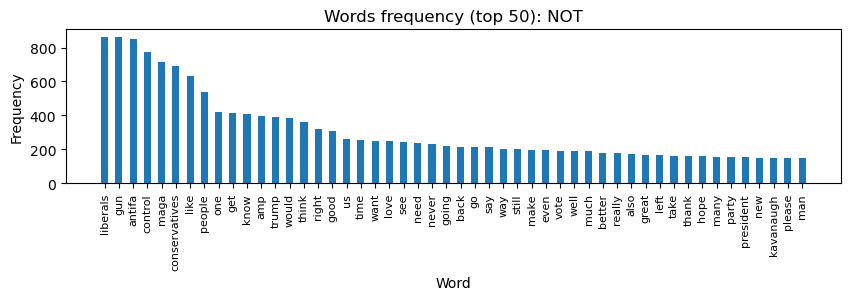

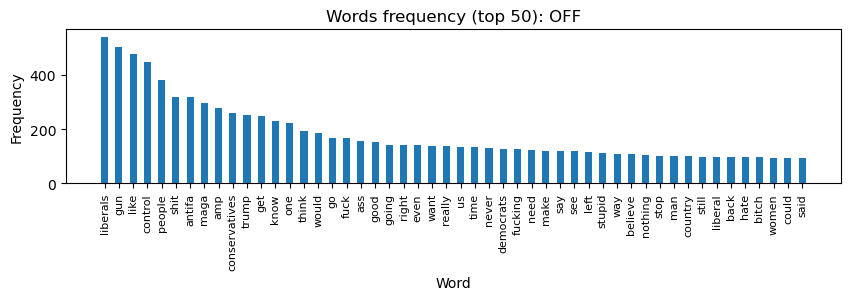

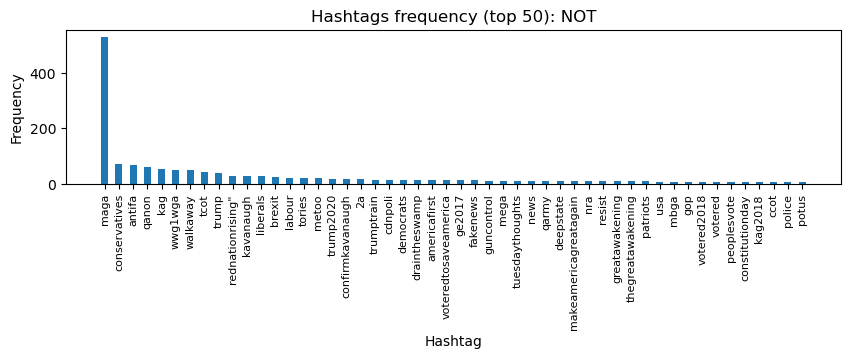

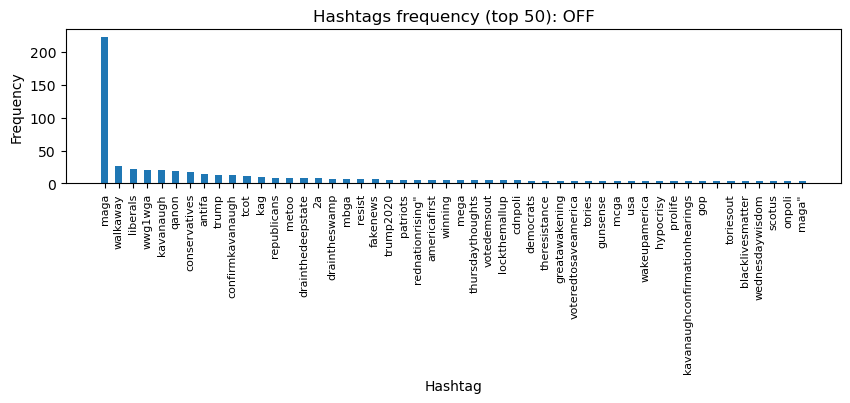

In [649]:
# Tweets word clustering by labels

class WordFrequencyClassifier:
    FIGURE_SIZE = (10,2)
    BAR_WIDTH = 0.5
    TOP_K_WORDS_TO_PLOT = 50
    
    _bow_words_clf = None
    _bow_hashtags_clf = None
    
    _words_count_vect = CountVectorizer()
    _hashtags_count_vect = CountVectorizer()

    tokens_by_label = { "NOT": [], "OFF": [] }
    hashtags_by_label = { "NOT": [], "OFF": [] }

    def __init__(self):
        print("Training TF-IDF model...")
        self._train_top_words()
        self._train_top_hashtags()
        print("WordFrequencyClassifier has been initialized.")
        
    
    def _train_top_words(self):
        train_tweets_docs = []
        train_labels = []
        
        for index,uid,tweet,offensive,targeted,target_type in tqdm(train_ds.itertuples(), 
                                                                   desc="Analyzing tweets words..."):
            tokens = self._get_tokens(tweet)
            label = 'OFF' if offensive == 'OFF' else 'NOT'
            
            self.tokens_by_label[label] += tokens
            train_tweets_docs.append(" ".join(tokens))
            train_labels.append(label)
        
        train_counts = self._words_count_vect.fit_transform(train_tweets_docs)
        train_tfidf = TfidfTransformer().fit_transform(train_counts)
        self._bow_words_clf = MultinomialNB().fit(train_tfidf, train_labels)
        
    
    def _train_top_hashtags(self):
        train_hashtags_docs = []
        train_labels = []
        
        for index,uid,tweet,offensive,targeted,target_type in tqdm(train_ds.itertuples(), 
                                                                   desc="Analyzing tweets hashtags..."):
            label = 'OFF' if offensive == 'OFF' else 'NOT'
            hashtags = self._get_hashtags(tweet)
            
            self.hashtags_by_label[label] += hashtags
            train_hashtags_docs.append(" ".join(hashtags))
            train_labels.append(label)
        
        train_counts = self._hashtags_count_vect.fit_transform(train_hashtags_docs)
        train_tfidf = TfidfTransformer().fit_transform(train_counts)
        self._bow_hashtags_clf = MultinomialNB().fit(train_tfidf, train_labels)
    
    
    def _get_tokens(self, tweet: str) -> List[str]:
        return TweetUtils.tokenize_tweet(tweet)
    
    
    def _get_hashtags(self, tweet: str) -> List[str]:
        return TweetUtils.extract_hashtags(tweet)
    
            
    def plot_frequencies(self, data: Literal['words', 'hashtags']):
        if data == 'words':
            corpus = self.tokens_by_label
            title = 'Words frequency'
            xlabel = 'Word'
        elif data == 'hashtags':
            corpus = self.hashtags_by_label
            title = 'Hashtags frequency'
            xlabel = 'Hashtag'
        
        for label,tokens in corpus.items():
            counts = dict(Counter(tokens).most_common(self.TOP_K_WORDS_TO_PLOT))
            words, values = zip(*counts.items())
            
            sort = np.argsort(values)[::-1]
            values = np.array(values)[sort]
            words = np.array(words)[sort]
            indexes = np.arange(len(words))

            plt.figure(figsize=self.FIGURE_SIZE)
            plt.bar(indexes, values, width=self.BAR_WIDTH)
            plt.xticks(indexes, words, fontsize=8, rotation=90)
            plt.title(f"{title} (top {self.TOP_K_WORDS_TO_PLOT}): {label}")
            plt.xlabel(xlabel)
            plt.ylabel('Frequency')
            plt.show()
            
            
    def predict(self, tweet: str, data: Literal['words', 'hashtags']) -> str:
        if data == 'words':
            model = self._bow_words_clf
            c_vect = self._words_count_vect
        elif data == 'hashtags':
            model = self._bow_hashtags_clf
            c_vect = self._hashtags_count_vect
        
        pos_tokens = " ".join(self._get_tokens(tweet))
        prediction = model.predict(c_vect.transform([pos_tokens]))[0]
        
        return prediction
        

WordFreqClssifier = WordFrequencyClassifier()
WordFreqClssifier.plot_frequencies(data='words')
WordFreqClssifier.plot_frequencies(data='hashtags')

In [650]:
class Tweet(BaseModel):
    raw_text: Optional[str] = None
    text: Optional[str] = None
    sentiment: Optional[Literal['POS', 'NEU', 'NEG']] = None
    bow_words_prediction: Optional[int] = None
    bow_hashtags_prediction: Optional[int] = None
    hashtags: List[str] = []
    emojis: List[str] = []
    hashtags_count: Optional[int] = 0
    emojis_count: Optional[int] = 0
        
    def __init__(self, tweet: str, uid: Optional[str] = None):
        super().__init__()
        self.raw_text = tweet
        text, hashtags, emojis = TweetUtils.sanitize_tweet(tweet)
        
        self.text = text
        self.hashtags = hashtags
        self.hashtags_count = len(hashtags)
        self.emojis = emojis
        self.emojis_count = len(emojis)
        self.bow_words_prediction = CLASS_TO_LABEL[WordFreqClssifier.predict(tweet, data="words")]
        self.bow_hashtags_prediction = CLASS_TO_LABEL[WordFreqClssifier.predict(tweet, data="hashtags")]
        self.sentiment = tweet_sentiments[f"{uid}"] if uid else TweetSentimentModel.predict(tweet)

    
    def get_features(self):
        return {
            "tweet_length": len(self.raw_text),
            "words_count": len(self.raw_text.split()),
            "hashtags_count": self.hashtags_count,
            "emojis_count": self.emojis_count,
            "tags_count": self.raw_text.count('@USER'),
            "exclamation_mark_count": self.raw_text.count('!'),
            "all_caps_count": sum([1 if c.isupper() else 0 for c in self.raw_text]),
            "digits_count": sum([1 if c.isdigit() else 0 for c in self.raw_text]),
            "has_url": self.raw_text.count('URL') > 0,
            "sentiment": self.sentiment,
            "bow_words_prediction": self.bow_words_prediction,
            "bow_hashtags_prediction": self.bow_hashtags_prediction
        }


class LabeledTweet(Tweet):
    uid: Optional[str] = None
    is_offensive: Optional[bool] = False
    is_targeted: Optional[bool] = False
    offensive: Optional[Literal['OFF', 'NOT']] = None # offensive or not
    targeted: Optional[Literal['TIN', 'UNT']] = None # targeted or untargeted
    target_type: Optional[Literal['IND', 'GRP', 'OTH']] = None # individual, group or other
        
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    
    @property
    def features(self):
        return self.get_features()
        
    
    # 1: NOT OFFENSIVE
    # 2: OFFENSIVE, UNTARGETED
    # 3: OFFENSIVE, TARGETED, INDIVIDUAL
    # 4: OFFENSIVE, TARGETED, GROUP
    # 5: OFFENSIVE, TARGETED, OTHER
    @property
    def label(self) -> int:
        _label = 'NOT'
        
        if self.is_offensive:
            _label = 'OFF' if not self.is_targeted else self.target_type
        
        return CLASS_TO_LABEL[_label]
        

    @classmethod
    def from_sample(cls, 
                    tweet: str, 
                    uid: Optional[str] = None, 
                    offensive: Optional[str] = None, 
                    targeted: Optional[str] = None, 
                    target_type: Optional[str] = None):
        labeled_tweet = LabeledTweet(tweet=tweet, uid=uid)
        labeled_tweet.is_offensive = (offensive == 'OFF')
        labeled_tweet.is_targeted = (targeted == 'TIN')
        labeled_tweet.offensive = offensive
        labeled_tweet.targeted = None if pd.isna(targeted) else targeted
        labeled_tweet.target_type = None if pd.isna(target_type) else target_type
    
        return labeled_tweet

In [811]:
# Preprocess train data
train_tweets: Dict[str, LabeledTweet] = {}

print("Building training data...")
for index,uid,tweet,offensive,targeted,target_type in tqdm(train_ds.itertuples()):
    sample = LabeledTweet.from_sample(tweet=tweet, 
                                      uid=uid, 
                                      offensive=offensive, 
                                      targeted=targeted, 
                                      target_type=target_type)
    train_tweets[f"{uid}"] = sample

Building training data...


13240it [00:13, 961.95it/s] 


In [812]:
# Preprocess test data
test_tweets: Dict[str, LabeledTweet] = {}

print("Building test data...")
for index,uid,tweet in tqdm(test_lvl_a.itertuples()):
    sample = LabeledTweet.from_sample(uid=uid, tweet=tweet)
    test_tweets[f"{uid}"] = sample
    
for index,uid,offensive in test_lvl_a_labels.itertuples():
    test_tweets[f"{uid}"].is_offensive = (offensive == 'OFF')
    test_tweets[f"{uid}"].offensive = offensive
    
for index,uid,targeted in test_lvl_b_labels.itertuples():
    test_tweets[f"{uid}"].is_targeted = (targeted == 'TIN')
    test_tweets[f"{uid}"].targeted = targeted
    
for index,uid,target_type in test_lvl_c_labels.itertuples():
    test_tweets[f"{uid}"].target_type = target_type

Building test data...


860it [00:00, 936.16it/s]


In [813]:
print(f"Train dataset: {len(train_tweets)} tweets")
print(f"Test dataset: {len(test_tweets)} tweets")

Train dataset: 13240 tweets
Test dataset: 860 tweets


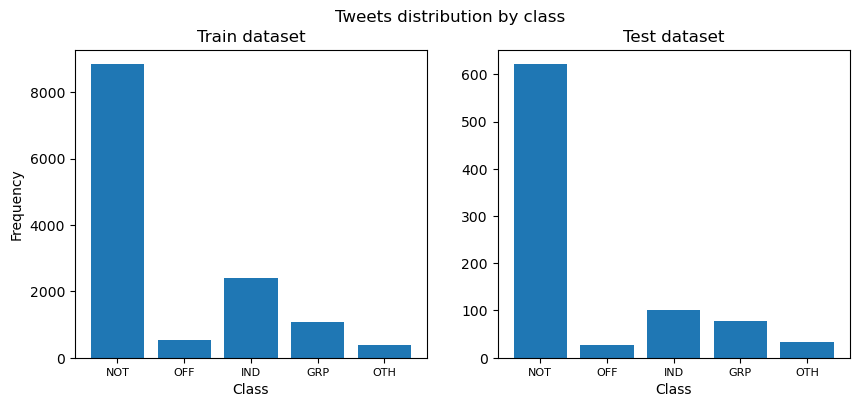

In [814]:
indexes = np.arange(5)
labels = CLASS_TO_LABEL.keys()
train_counts = []
test_counts = []

for label in labels:
    test_count = len([t for t in test_tweets.values() if LABEL_TO_CLASS[t.label] == label])
    train_count = len([t for t in train_tweets.values() if LABEL_TO_CLASS[t.label] == label])
    train_counts.append(train_count)
    test_counts.append(test_count)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.set_figheight(4)
fig.suptitle('Tweets distribution by class')

ax1.bar(indexes, train_counts)
ax1.set_title('Train dataset')
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Class')
ax1.set_xticks(indexes, labels, fontsize=8)

ax2.bar(indexes, test_counts)
ax2.set_title('Test dataset')
ax2.set_xlabel('Class')
ax2.set_xticks(indexes, labels, fontsize=8)

plt.show()

#### Creating the classifier

In [815]:
class TweetsBullyingClassifier():
    def __init__(self):
        self._vectorizer = DictVectorizer()
        self._model = LogisticRegressionCV(cv=10)
        
    def _process_train_data(self, train_data: List[LabeledTweet]):
        features = []
        labels = []

        for tweet in tqdm(train_data, desc="Preprocessing train data..."):
            features.append(tweet.features)
            labels.append(tweet.label)

        return features, labels
        
    
    def train(self, train_data) -> None:
        features, labels = self._process_train_data(train_data)

        print("Training model...")
        self._vectorizer.fit(features)
        self._model.fit(self._vectorizer.transform(features), labels)
        print("Done.")
        
    
    def predict(self, tweet) -> str:
        predicted = self._model.predict(
            self._vectorizer.transform(Tweet(tweet=tweet).get_features())
        )[0]
        
        return {
            "label": predicted,
            "class": LABEL_TO_CLASS[predicted]
        }
    

    def evaluate(self, test_data: List[LabeledTweet]) -> float:
        print("Evaluating model...")
        samples_count = len(test_data)
        predictions = []

        for sample in tqdm(test_data, desc="Test data evaluation..."):
            features, true_label = [sample.features, sample.label]
            prediction = self._model.predict(self._vectorizer.transform(features))
            predictions.append(prediction)
        
        true_labels = [t.label for t in test_tweets.values()]
        cm = confusion_matrix(y_true=true_labels, y_pred=predictions)
        scores = classification_report(y_true=true_labels, y_pred=predictions)
        
        return scores, cm

In [816]:
classifier = TweetsBullyingClassifier()
classifier.train(train_tweets.values())

Preprocessing train data...: 100%|███████████████| 13240/13240 [00:00<00:00, 34450.93it/s]


Training model...
Done.


Evaluating model...


Test data evaluation...: 100%|████████████████████████| 860/860 [00:00<00:00, 7168.64it/s]

              precision    recall  f1-score   support

           1       0.79      0.98      0.88       621
           2       0.00      0.00      0.00        27
           3       0.34      0.29      0.31       100
           4       0.67      0.03      0.05        78
           5       0.00      0.00      0.00        34

    accuracy                           0.74       860
   macro avg       0.36      0.26      0.25       860
weighted avg       0.67      0.74      0.67       860



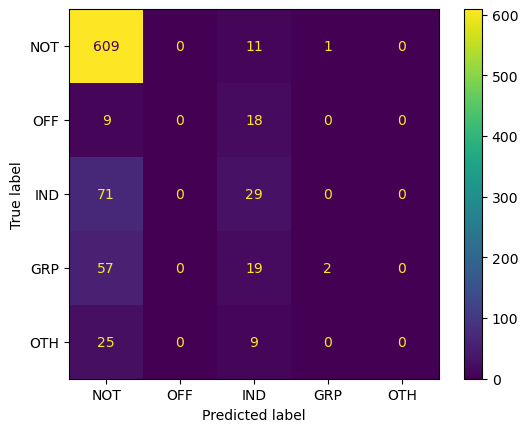

In [817]:
scores, cm = classifier.evaluate(list(test_tweets.values()))

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABEL_TO_CLASS.values()).plot()
print(scores)

---

### Trends Analysis

Showing two differetn applications of the _TweetsBullyingClassifier_ model to demonstate possible offensive trends extraction from a given tweets dataset.

In [822]:
# Plotting utilities

def plot_frequency_histogram(ax, words: List[Tuple[str, int]], title: str, color: str):
    ax.set_title(title)
    ax.set_ylabel('Frequency (%)')
    ax.set_xticks(np.arange(len(words)), [w for w,count in words], rotation=90, fontsize=9)

    pps = ax.bar([w for w,_ in words], 
                 [100 * count / sum([c for _, c in words]) for _, count in words], 
                 color=color)

    for i,p in enumerate(pps):
        ax.annotate(f"{words[i][1]:.0f}",
                    xy=(p.get_x() + p.get_width() / 2, p.get_height()),
                    fontsize=7, xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
    
    
def plot_bigrams_barchart(ax, bigrams: List[Tuple[Tuple[str, str], int]], title: str, color: str): 
    ax.set_title(title)
    ax.set_ylabel('Frequency (%)')
    ax.set_xticks(np.arange(len(bigrams)), 
                  [" ".join(ws) for ws,count in bigrams], rotation=90, fontsize=9)

    pps = ax.bar([str(bg) for bg in bigrams], 
                 [100 * count / sum([c for _, c in bigrams]) for _, count in bigrams], 
                 color=color)

    for i,p in enumerate(pps):
        ax.annotate(f"{bigrams[i][1]:.0f}",
                    xy=(p.get_x() + p.get_width() / 2, p.get_height()),
                    fontsize=7, xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
        

def plot_word_cloud(ax, words: List[Tuple[Tuple[str, str], int]], 
                    top_k: int, top_k_color: str, bigrams: bool = False): 
    wc_counts = {"_".join(w):count for w, count in words} if bigrams else {str(w):count for w,count in words}
    sorted_words = sorted(wc_counts.items(), reverse=True, key=lambda x:x[1])
    wc = WordCloud(width=800, height=400, background_color='white', max_font_size=48, relative_scaling=0.3)
    wordcloud = wc.generate_from_frequencies(wc_counts)
    wordcloud.recolor(color_func=lambda word, **kwargs: top_k_color 
                      if [w for w,c in sorted_words].index(word) <= top_k else 'grey')

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')

### Common bigram analysis over the dataset

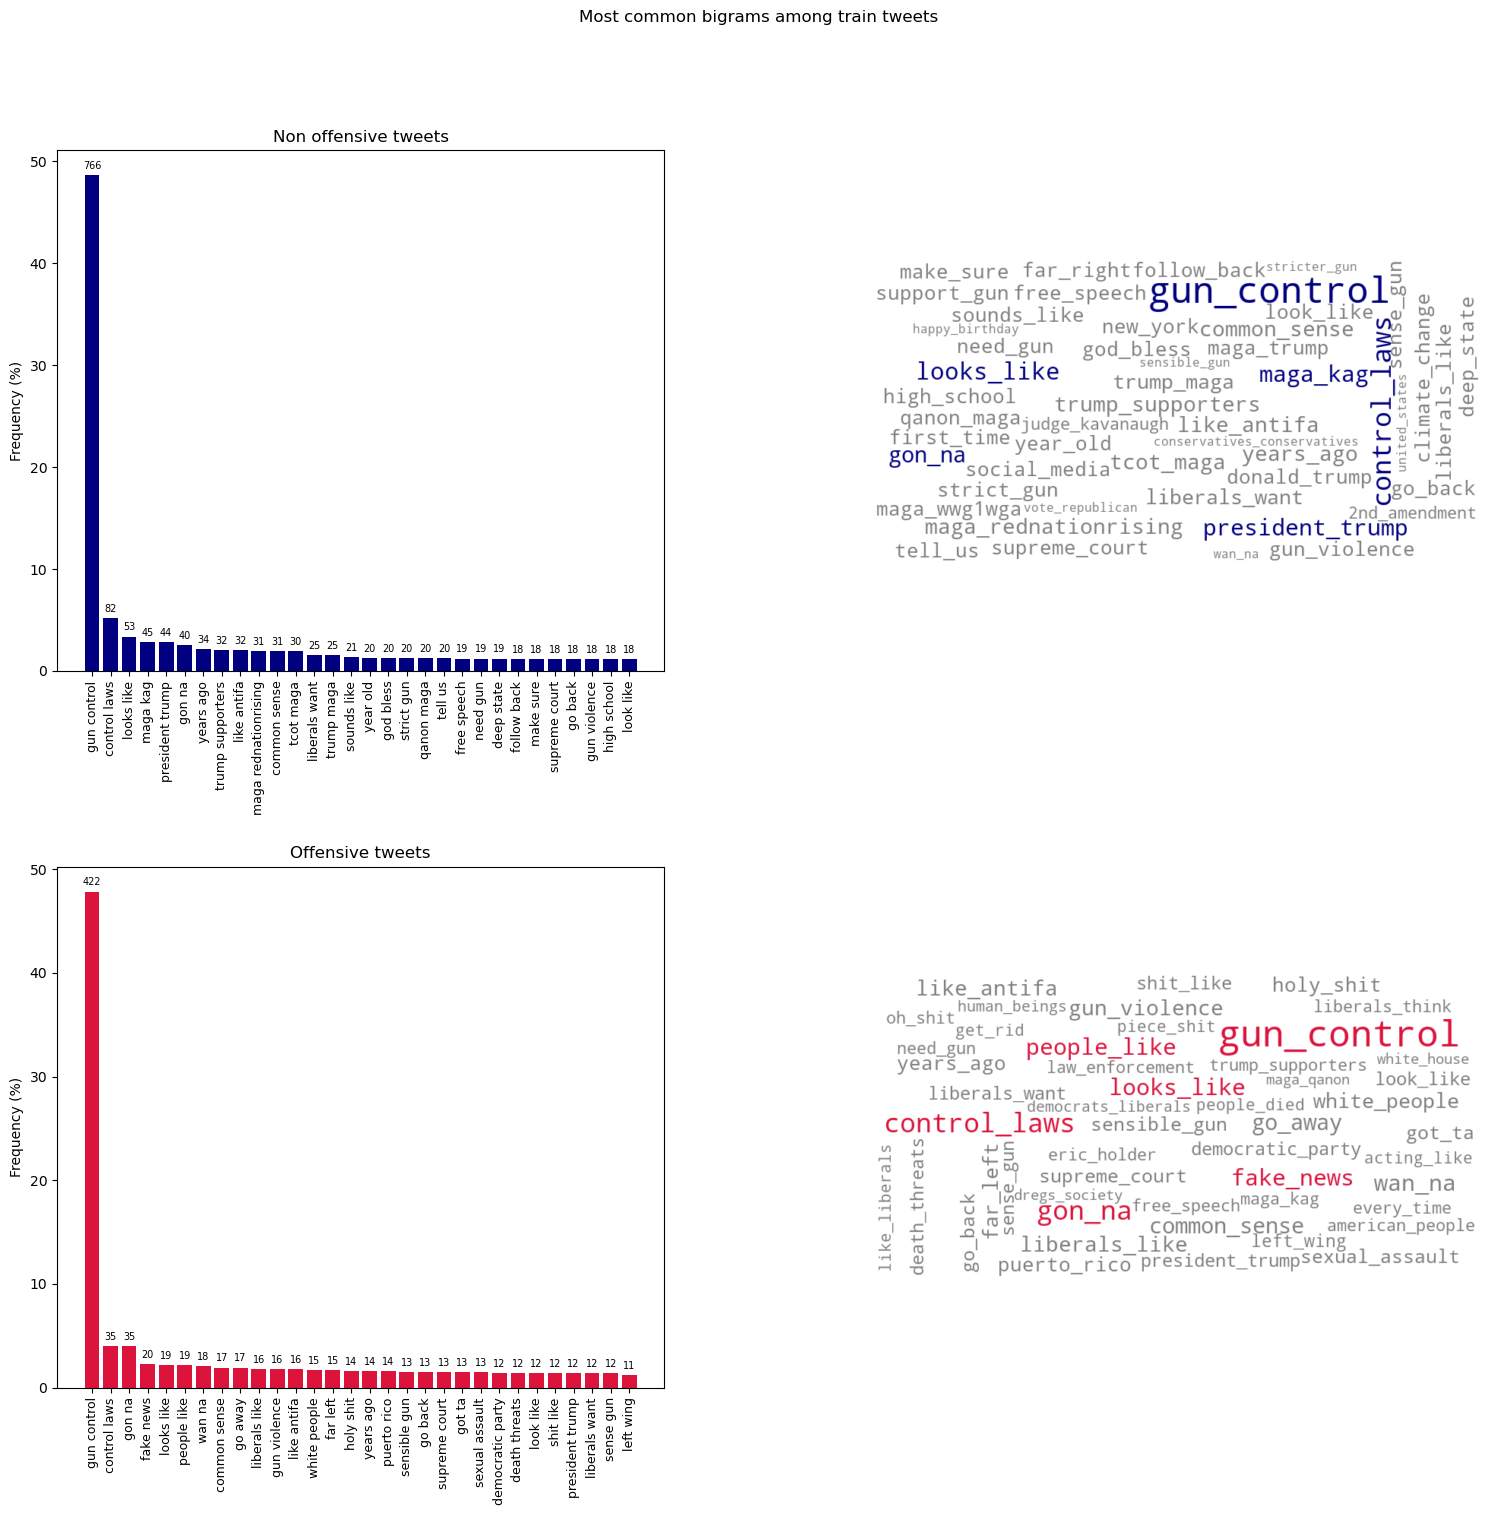

In [819]:
# Extracting common bigrams from offensive and non-offensive tweets
all_tweets = {**train_tweets, **test_tweets}
non_offensive_tweets = [t.raw_text for t in all_tweets.values() if not t.is_offensive]
offensive_tweets = [t.raw_text for t in all_tweets.values() if t.is_offensive or t.is_targeted]

wc_k_top_bigrams = 50
barchart_k_top_bigrams = 30

non_offensive_words = np.concatenate([TweetUtils.tokenize_tweet(t) for t in non_offensive_tweets])
non_offensive_bigrams = list(bigrams(non_offensive_words))
offensive_words = np.concatenate([TweetUtils.tokenize_tweet(t) for t in offensive_tweets])
offensive_bigrams = list(bigrams(offensive_words))

nof_bigrams = FreqDist(non_offensive_bigrams)
off_bigrams = FreqDist(offensive_bigrams)
    
    
fig, (ax1, ax2) = plt.subplots(2, 2)
fig.set_figwidth(18)
fig.set_figheight(16)
fig.tight_layout(pad=12)
fig.suptitle('Most common bigrams among train tweets')

plot_bigrams_barchart(ax=ax1[0], bigrams=nof_bigrams.most_common(barchart_k_top_bigrams), 
                      title="Non offensive tweets", color="navy")

plot_word_cloud(ax=ax1[1], 
                words=nof_bigrams.most_common(wc_k_top_bigrams), 
                top_k=5, 
                top_k_color="navy", 
                bigrams=True)

plot_bigrams_barchart(ax=ax2[0], bigrams=off_bigrams.most_common(barchart_k_top_bigrams), 
                      title="Offensive tweets", color="crimson")

plot_word_cloud(ax=ax2[1], 
                words=off_bigrams.most_common(wc_k_top_bigrams), 
                top_k=5, 
                top_k_color="crimson",
                bigrams=True)

fig.show()

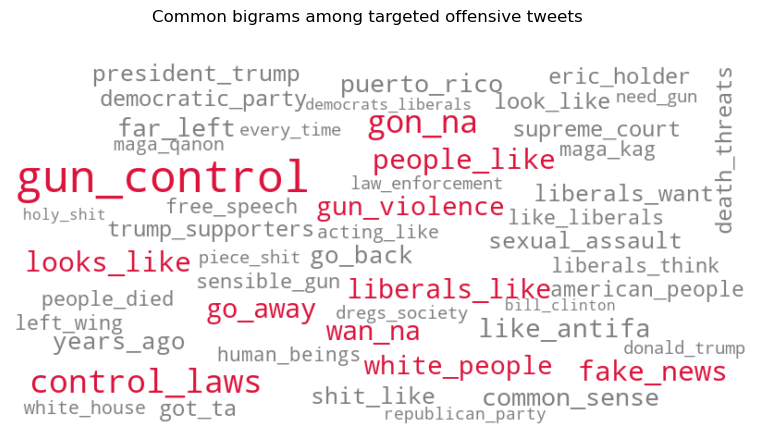

In [824]:
targeted_tweets = [t.raw_text for t in all_tweets.values() if t.is_targeted]
words = np.concatenate([TweetUtils.tokenize_tweet(tweet=t) for t in targeted_tweets])
targeted_bigrams = FreqDist(list(bigrams(words)))

fig, ax = plt.subplots(1,1)
fig.suptitle('Common bigrams among targeted offensive tweets')
fig.set_figwidth(10)

plot_word_cloud(ax=ax, 
                words=targeted_bigrams.most_common(wc_k_top_bigrams), 
                top_k=10, 
                top_k_color="crimson",
                bigrams=True)

fig.show()

### Donald Trump's offensive tweets trending targets

Using Donald Trump's tweets datasets from his time as a **candidate** for the US presidency, compared to his time as **US president**. We can see how the trending targets pre-office were mainly his political rivals, while in-office tweets focuses mainly on blaming others and avoiding critism.

In [682]:
trump_offensive_tweets_before_office = []
trump_offensive_tweets_in_office = []

for tweet in tqdm(trump_tweets_before_office_ds['text'], desc="Classifying Trump's pre-office tweets..."):
    prediction = classifier.predict(tweet)['label']
    if prediction > 2:
        trump_offensive_tweets_before_office.append(tweet)


for tweet in tqdm(trump_tweets_in_office_ds['text'], desc="Classifying Trump's in-office tweets..."):
    prediction = classifier.predict(tweet)['label']
    if prediction > 2:
        trump_offensive_tweets_in_office.append(tweet)

Classifying Trump's in-office tweets...: 100%|████████████████████████████████████████████| 5000/5000 [18:12<00:00,  4.58it/s]


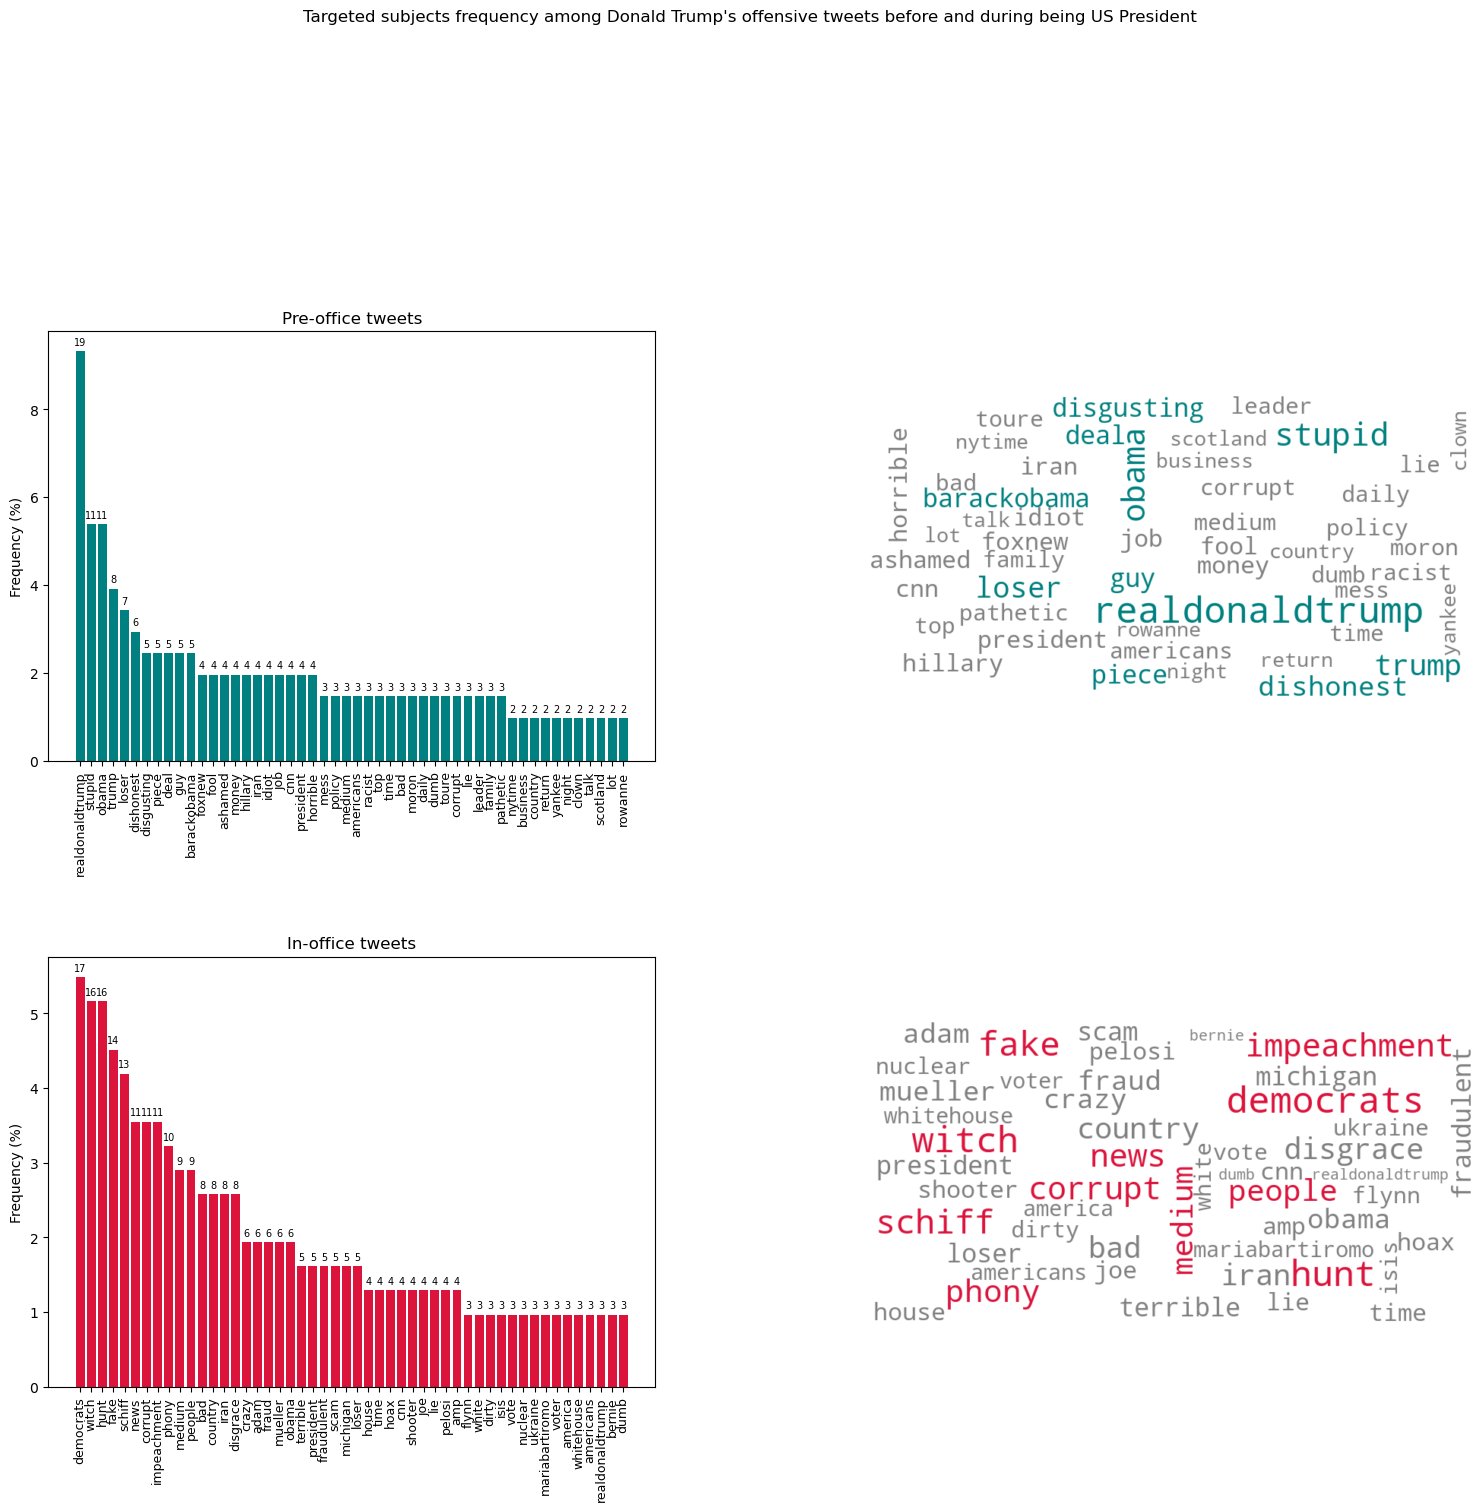

In [821]:
TARGET_POS_TAGS = ['NOUN', 'PROPN', 'ADJ']
SKIP_TOKENS = ['http', 'https', 'total', 'rt']
TOP_K_WORDS = 50

pre_office_trends = FreqDist(np.concatenate([
    TweetUtils.tokenize_tweet(tweet=t, target_pos=TARGET_POS_TAGS, skip_tokens=SKIP_TOKENS) 
    for t in trump_offensive_tweets_before_office
])).most_common(TOP_K_WORDS)

in_office_trends = FreqDist(np.concatenate([
    TweetUtils.tokenize_tweet(tweet=t, target_pos=TARGET_POS_TAGS, skip_tokens=SKIP_TOKENS) 
    for t in trump_offensive_tweets_in_office
])).most_common(TOP_K_WORDS)

fig, (ax1, ax2) = plt.subplots(2, 2)
fig.suptitle("Targeted subjects frequency among Donald Trump's offensive tweets before and during being US President")
fig.set_figwidth(18)
fig.set_figheight(16)
fig.tight_layout(pad=12)

plot_frequency_histogram(ax=ax1[0],
                         words=pre_office_trends,
                         title="Pre-office tweets", color="teal")

plot_word_cloud(ax=ax1[1], 
                words=pre_office_trends,
                top_k_color="teal", top_k=10)

plot_frequency_histogram(ax=ax2[0],
                         words=in_office_trends,
                         title="In-office tweets", color="crimson")

plot_word_cloud(ax=ax2[1], 
                words=in_office_trends,
                top_k_color="crimson", top_k=10)